In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, RandomSampler
import time
import torch.nn as nn

In [2]:
cifar_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
# from https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torchvision
import torchvision.transforms as transforms

# transform = transforms.Compose(
    # [transforms.ToTensor(),
    #  transforms.Normalize((0.5,), (0.5,))])

batch_size = 4

trainset = torchvision.datasets.MNIST(root='./data', 
                                      train=True,
                                      download=True, 
                                      #transform=transform
                                      )

testset = torchvision.datasets.MNIST(root='./data', 
                                     train=False,
                                     download=True,
                                     #transform=transform
                                     )

In [4]:
from torch.utils.data import TensorDataset

def filter_classes_MNIST(dataset, classes_to_keep):

    # Get data and targets
    data = dataset.data.flatten(start_dim=1)
    targets = dataset.targets

    # Create mask
    mask = (targets == classes_to_keep[0]) | (targets == classes_to_keep[1])

    # Apply mask
    filtered_data = (data[mask] / 255).float()

    label_map = {classes_to_keep[0]: 0, classes_to_keep[1]: 1}
    filtered_targets = torch.tensor([label_map[t.item()] for t in targets[mask]])

    return TensorDataset(filtered_data, filtered_targets)

In [5]:
mnist_01_train = filter_classes_MNIST(trainset, [0,1])
mnist_01_test = filter_classes_MNIST(testset, [0,1])

In [6]:
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 2))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

In [7]:
# check https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
# check https://github.com/shaoanlu/dogs-vs-cats-redux/blob/master/opt_experiment.ipynb

In [8]:
# torch.manual_seed(42)
# np.random.seed(42)

DATASET_SIZE = 1000
DATASET_DIM = 20
DATASET_CLUSTER_COUNT = 5
DATASET_R = 20

In [9]:
from cluster_tools import kmeans_elbow, ClusterSampler, process_2_labels

Samplers

In [10]:
from torch import nn

LAMBDA = 1e-4 # L2 regularization

class LogisticLossModel(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        assert len(dataset.shape) == 2, "Do not use with images"
        dim = dataset.shape[1]
        self.layer = nn.Linear(dim, 1, bias=True)
        self.layer.weight.data.fill_(0)
        self.layer.bias.data.fill_(0)
    
    def forward(self, ai):
        x = self.layer(ai)
        res = torch.log(1 + torch.exp(x))
        return res.flatten() + LAMBDA*self.layer.weight.norm()
    

def regress_criterion(output, batch):
    return output.mean()

In [37]:
from sklearn.datasets import make_blobs
clustered_data, _ = make_blobs(n_samples=DATASET_SIZE, 
                              n_features=DATASET_DIM,
                              centers=DATASET_CLUSTER_COUNT,
                              random_state=42)

clustered_data = torch.from_numpy(clustered_data.astype(np.float32))
clustered_data = (clustered_data - clustered_data.mean()) / np.sqrt(clustered_data.var())
labels = torch.zeros(DATASET_SIZE)

In [38]:
clustered_data, labels = mnist_01_train.tensors

In [39]:
labeled_data = process_2_labels(mnist_01_train)

In [40]:
# probably utils function
from utils import dimension_reduction

compressed_data = dimension_reduction(clustered_data, alg="tsne")

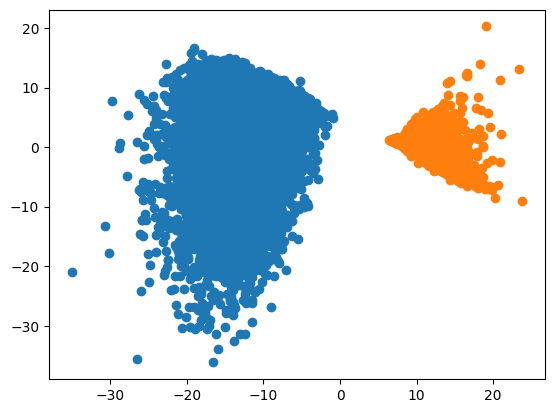

In [41]:
compressed_labeled = dimension_reduction(labeled_data, alg="pca")
mask_0 = (labels == 0)
mask_1 = (labels == 1)
plt.scatter(compressed_labeled[mask_0,0], compressed_labeled[mask_0,1])
plt.scatter(compressed_labeled[mask_1,0], compressed_labeled[mask_1,1])

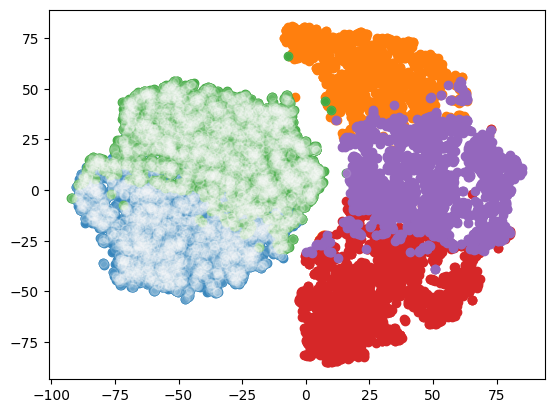

In [42]:
cluster_sampler = ClusterSampler(labeled_data, 64)
for i in range(cluster_sampler.cluster_count):
    selected = compressed_data[cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

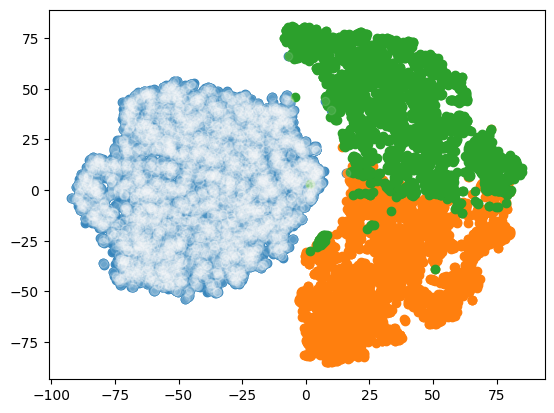

In [43]:
from cluster_tools import kmeans_cos_elbow

cosine_cluster_sampler = ClusterSampler(labeled_data, 64, kmeans_cos_elbow)
for i in range(cosine_cluster_sampler.cluster_count):
    selected = compressed_data[cosine_cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

Solvers

In [47]:
# finding an exact solution

from tqdm import tqdm

model = LogisticLossModel(labeled_data)

curr_epoch = 0
losses = []
lr = 10

while 1:
    model.zero_grad()
    output = model(labeled_data)
    loss = regress_criterion(output, "")
    loss.backward()
    for p in model.parameters():
        p.data.sub_(lr*p.grad.data)
    losses.append(loss.item())
    curr_epoch += 1
    if curr_epoch % 5000 == 0:
        print(curr_epoch, loss.item())
    if curr_epoch > 1 and losses[-2] - losses[-1] < 1e-11:
        break

opt_val = losses[-1]
print(curr_epoch, opt_val)

5000 0.0008978942641988397
10000 0.00039495262899436057
15000 2.9100692700012587e-05
15423 2.6032086680061184e-05


[]

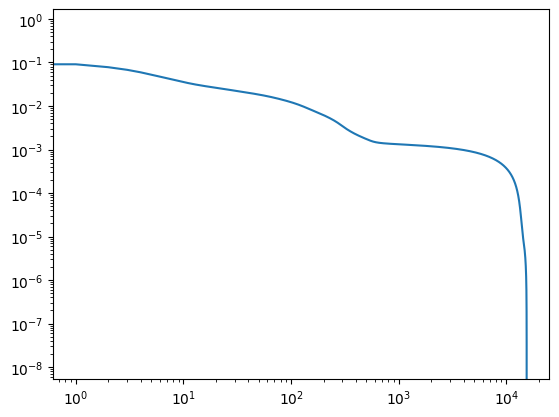

In [48]:
plt.plot(np.array(losses)-opt_val)
# plt.yscale("log")
plt.loglog()

In [24]:
from solvers import solve_problem, svrg, COVER, clusterSVRG

In [25]:
from utils import clone_model

In [60]:
NB_EPOCH = 50
TIME_LIM = None # 25
BATCH_SIZE = 64

REPEAT_TIMES = 10

In [105]:
base_model = LogisticLossModel(clustered_data)
lr = 2
lr_one_t = lambda epoch: 5 / (epoch+1)
lr_log_t = lambda epoch: 5 * np.log(epoch+1) / (epoch+1)

In [62]:
from torch.utils.data import TensorDataset

dataset = TensorDataset(labeled_data, labels) # clustered_dataset

In [63]:
cluster_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=cluster_sampler)
cosine_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=cosine_cluster_sampler)

iid_sampler = RandomSampler(dataset, replacement=True)
iid_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=iid_sampler)

In [ ]:
svrg_time, svrg_sol, _ = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader(dataset, BATCH_SIZE, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                learning_rate=lr,
                lr_lambda=lr_log_t)

In [ ]:
cover_time, cover_sol, _ = COVER(clone_model(base_model, clustered_data),
                     regress_criterion,
                     dataset,
                     RandomSampler(dataset),
                     clustered_data,
                     n_epoch=None,
                     time_lim=TIME_LIM,
                     learning_rate=lr,
                     lr_lambda=lr_log_t)

  0%|          | 6/100000 [00:33<155:05:10,  5.58s/it]


In [ ]:
clusterSVRG_time, clusterSVRG_sol, _ = clusterSVRG(clone_model(base_model, clustered_data),
                     regress_criterion,
                     dataset,
                     RandomSampler(dataset),
                     clustered_data,
                     n_epoch=None,
                     time_lim=TIME_LIM,
                     learning_rate=lr,
                     lr_lambda=lr_log_t)

  0%|          | 3/100000 [00:34<320:36:28, 11.54s/it]


In [ ]:
grad_des_time, grad_des_sol, _ = solve_problem(
    clone_model(base_model, clustered_data), 
    regress_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, len(clustered_data)),
    n_epoch=NB_EPOCH,
    time_lim=TIME_LIM,
    verbose=True,
    lr=lr,
    # lr_lambda=lr_log_t,
    )

Building models...


  0%|          | 158/100000 [00:30<5:18:07,  5.23it/s]


In [ ]:
svrg_single_time, svrg_single_sol, _ = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader(dataset, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                learning_rate=lr,
                lr_lambda=lr_log_t)

  0%|          | 3/100000 [00:39<363:39:27, 13.09s/it]


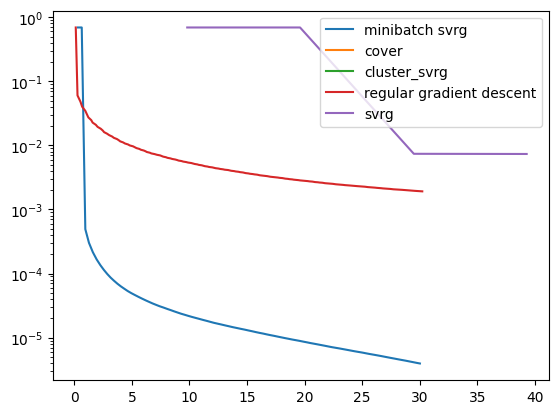

In [ ]:
plt.plot(svrg_time, svrg_sol-opt_val, label="minibatch svrg")
plt.plot(cover_time, cover_sol-opt_val, label="cover")
plt.plot(clusterSVRG_time, clusterSVRG_sol-opt_val, label="cluster_svrg")
plt.plot(grad_des_time, grad_des_sol-opt_val, label="regular gradient descent")
plt.plot(svrg_single_time, svrg_single_sol-opt_val, label="svrg")
plt.yscale("log")
plt.legend()
plt.show()

In [107]:
sgd_times, sgd_sols = [], []
for i in range(REPEAT_TIMES):
    sgd_time, sgd_sol, _ = solve_problem(clone_model(base_model, clustered_data), 
                regress_criterion,
                optimizer_class=torch.optim.SGD,
                dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                verbose=True,
                lr=lr,
                lr_lambda=lr_log_t)
    sgd_times.append(sgd_time)
    sgd_sols.append(sgd_sol)

Building models...


100%|██████████| 50/50 [00:50<00:00,  1.00s/it]


Building models...


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Building models...


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Building models...


100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


Building models...


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


Building models...


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Building models...


100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


Building models...


100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


Building models...


100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


Building models...


100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


In [ ]:
adam_time, adam_sol, _ = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.Adam,
              dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
              n_epoch=NB_EPOCH,
              time_lim=TIME_LIM,
              verbose=True,
              lr=lr,
              lr_lambda=lr_log_t)

Building models...


  0%|          | 92/100000 [00:25<7:34:03,  3.67it/s]


In [ ]:
plt.plot(sgd_time, sgd_sol-opt_val, label="sgd")
plt.plot(adam_time, adam_sol-opt_val, label="adam")
plt.plot(svrg_time, svrg_sol-opt_val, label="svrg")
plt.plot(grad_des_time, grad_des_sol-opt_val, label="regular gradient descent")
plt.xlabel("time (s)")
plt.legend()
plt.yscale("log")
plt.show()

In [108]:
sgd_iid_times, sgd_sols_iid = [], []
for i in range(REPEAT_TIMES):
    sgd_iid_time, sgd_sol_iid, _ = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.SGD,
              dataloader=iid_dataloader,
              n_epoch=NB_EPOCH,
              time_lim=TIME_LIM,
              verbose=True,
              lr=lr,
              lr_lambda=lr_log_t)
    sgd_iid_times.append(sgd_iid_time)
    sgd_sols_iid.append(sgd_sol_iid)

Building models...


100%|██████████| 50/50 [00:13<00:00,  3.82it/s]


Building models...


100%|██████████| 50/50 [00:13<00:00,  3.82it/s]


Building models...


100%|██████████| 50/50 [00:12<00:00,  3.92it/s]


Building models...


100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


Building models...


100%|██████████| 50/50 [00:13<00:00,  3.78it/s]


Building models...


100%|██████████| 50/50 [00:13<00:00,  3.78it/s]


Building models...


100%|██████████| 50/50 [00:12<00:00,  3.90it/s]


Building models...


100%|██████████| 50/50 [00:12<00:00,  3.92it/s]


Building models...


100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


Building models...


100%|██████████| 50/50 [00:12<00:00,  3.91it/s]


In [109]:
sgd_cluster_times, sgd_sols_cluster = [], []
for i in range(REPEAT_TIMES):
    sgd_cluster_time, sgd_sol_cluster, _ = solve_problem(clone_model(base_model, clustered_data), 
                regress_criterion,
                optimizer_class=torch.optim.SGD,
                dataloader=cluster_dataloader,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                verbose=True,
                lr=lr,
                lr_lambda=lr_log_t)
    sgd_cluster_times.append(sgd_cluster_time)
    sgd_sols_cluster.append(sgd_sol_cluster)

Building models...


100%|██████████| 50/50 [00:20<00:00,  2.38it/s]


Building models...


100%|██████████| 50/50 [00:20<00:00,  2.42it/s]


Building models...


100%|██████████| 50/50 [00:20<00:00,  2.43it/s]


Building models...


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


Building models...


100%|██████████| 50/50 [00:19<00:00,  2.61it/s]


Building models...


100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


Building models...


100%|██████████| 50/50 [00:20<00:00,  2.50it/s]


Building models...


100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


Building models...


100%|██████████| 50/50 [00:20<00:00,  2.50it/s]


Building models...


100%|██████████| 50/50 [00:20<00:00,  2.50it/s]


In [110]:
sgd_cosine_times, sgd_sols_cosine = [],[]

for i in range(REPEAT_TIMES):
    sgd_cosine_time, sgd_sol_cosine, _ = solve_problem(clone_model(base_model, clustered_data), 
                regress_criterion,
                optimizer_class=torch.optim.SGD,
                dataloader=cosine_dataloader,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                verbose=True,
                lr=lr,
                lr_lambda=lr_log_t)
    sgd_cosine_times.append(sgd_cosine_time)
    sgd_sols_cosine.append(sgd_sol_cosine)

Building models...


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


Building models...


100%|██████████| 50/50 [00:19<00:00,  2.52it/s]


Building models...


100%|██████████| 50/50 [00:20<00:00,  2.49it/s]


Building models...


100%|██████████| 50/50 [00:21<00:00,  2.29it/s]


Building models...


100%|██████████| 50/50 [00:20<00:00,  2.41it/s]


Building models...


100%|██████████| 50/50 [00:20<00:00,  2.46it/s]


Building models...


100%|██████████| 50/50 [00:20<00:00,  2.46it/s]


Building models...


100%|██████████| 50/50 [00:20<00:00,  2.41it/s]


Building models...


100%|██████████| 50/50 [00:20<00:00,  2.46it/s]


Building models...


100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


In [111]:
# from solvers import weighted_solver
# sgd_alt_cluster_t, sgd_alt_cluster, _ = weighted_solver(
#     clone_model(base_model, clustered_data), 
#     regress_criterion,
#     torch.optim.SGD,
#     dataset,
#     n_iter=None,
#     time_lim=TIME_LIM,
#     verbose=True
# )

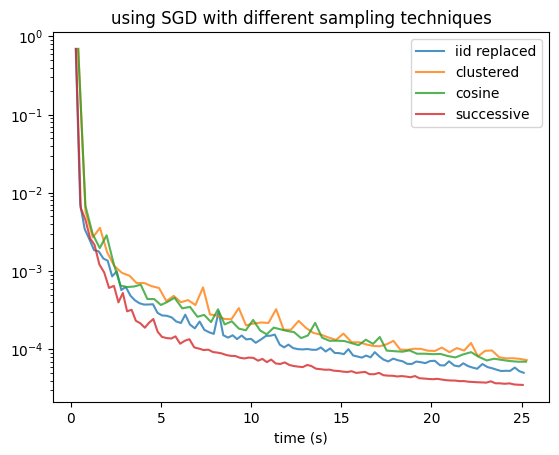

In [ ]:
plt.plot(sgd_iid_time, sgd_sol_iid-opt_val, label="iid replaced", alpha=0.8)
plt.plot(sgd_cluster_time, sgd_sol_cluster-opt_val, label="clustered", alpha=0.8)
plt.plot(sgd_cosine_time, sgd_sol_cosine-opt_val, label="cosine", alpha=0.8)
plt.plot(sgd_time, sgd_sol-opt_val, label="successive", alpha=0.8)

plt.legend()
plt.yscale("log")
plt.xlabel("time (s)")
plt.title("using SGD with different sampling techniques")
plt.show()

In [112]:
np.savetxt("./saves/sgd_iid_b8.txt", np.array(sgd_sols_iid))
np.savetxt("./saves/sgd_clustered_b8.txt", np.array(sgd_sols_cluster))
np.savetxt("./saves/sgd_cosine_b8.txt", np.array(sgd_sols_cosine))
np.savetxt("./saves/sgd_b8.txt", np.array(sgd_sols))

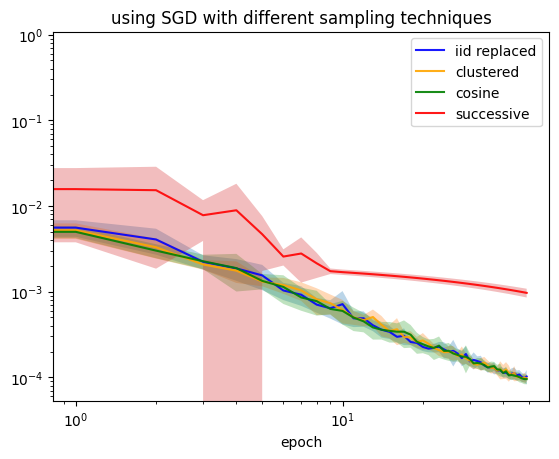

In [113]:
def plot_mult_iter(losses, opt_val, color, label):
    ls = np.array(losses)
    # for l in losses:
        # plt.plot(l-opt_val, alpha=0.1, color=color)
    m = np.mean(ls, axis=0)
    std = np.std(ls, axis=0)
    l = len(m)
    plt.plot(m-opt_val, color=color, label=label, alpha=0.9)
    plt.fill_between(np.arange(l), m-opt_val-std, m-opt_val+std, alpha=0.3)

plot_mult_iter(sgd_sols_iid, opt_val, color="blue", label="iid replaced")
plot_mult_iter(sgd_sols_cluster, opt_val, color="orange", label="clustered")
plot_mult_iter(sgd_sols_cosine, opt_val, color="green", label="cosine")
plot_mult_iter(sgd_sols, opt_val, color="red", label="successive")

plt.legend()
# plt.yscale("log")
plt.loglog()
plt.xlabel("epoch")
plt.title("using SGD with different sampling techniques")
plt.show()

In [34]:
def get_grad(batch, model):
    ret = np.zeros_like(batch)
    for i, elem in enumerate(batch):
        res = model(elem)
        l = regress_criterion(res, "")
        model.zero_grad()
        l.backward()
        ret[i] = (next(model.parameters()).grad.data.detach().numpy().squeeze())
    return ret

In [35]:
from torch import Tensor

def display_grads(dataset_torch:Tensor, model, cluster_sampler, alg="pca", title=""):
    gradients = np.zeros_like(dataset_torch)
    lims = [0]
    for i in range(cluster_sampler.cluster_count):
        selected = dataset_torch[cluster_sampler.clusters[i]]
        grad_selected = get_grad(selected, model)
        lims.append(lims[-1] + len(cluster_sampler.clusters[i]))
        gradients[lims[-2]:lims[-1], :] = grad_selected
    
    reduced = dimension_reduction(gradients, alg=alg)

    for i in range(cluster_sampler.cluster_count):
        plt.scatter(reduced[lims[i]:lims[i+1],0], reduced[lims[i]:lims[i+1],1], alpha=0.5)
    plt.title(title)
    plt.show()

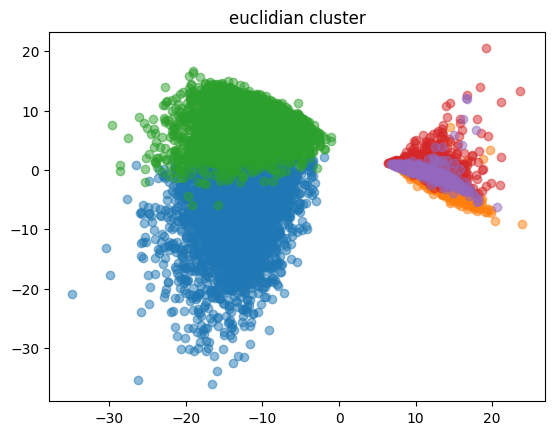

In [49]:
display_grads(labeled_data, model, cluster_sampler, title="euclidian cluster")

In [123]:
all_grads = get_grad(labeled_data, model)
full_grad = np.mean(all_grads, axis=0)

In [124]:
# checking the variance, see how much it's reduced...
def histogram(dataloader:DataLoader, label=None):
    res = []
    print("calculating for {}".format(label))
    for (batch, labels) in dataloader:
        batch_grads = get_grad(batch, model)
        res.append(np.sum((np.mean(batch_grads, axis=0) - full_grad)**2))
    return res[:-1]
    # plt.hist(res, density=True, label=label, alpha=1, histtype="step")
    # return np.array(res)
    
res_iid = histogram(iid_dataloader, "iid"),
res_cluster = histogram(cluster_dataloader, "cluster"),
res_cos = histogram(cosine_dataloader, "cosine"),
res_successive = histogram(DataLoader(dataset, BATCH_SIZE), "successive")
# plt.legend()
# plt.show()


calculating for iid
calculating for cluster
calculating for cosine
calculating for successive


4.614066995145549e-08
1.9343104895597207e-08
2.2055584025792996e-08
6.406725105989608e-08


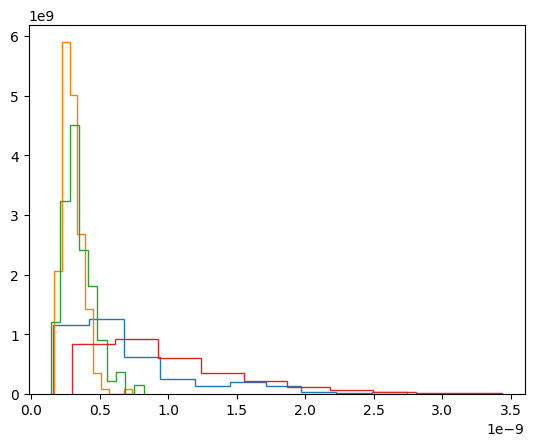

In [125]:
for res in [res_iid, res_cluster, res_cos, res_successive]:
    print(np.mean(res)*BATCH_SIZE)
    plt.hist(res, density=True, histtype="step")

In [96]:
print(np.sum((all_grads - full_grad)**2)/len(labeled_data))

4.626545732259233e-08


In [98]:
for i in range(cluster_sampler.cluster_count):
    all_cluster_grads = get_grad(labeled_data[cluster_sampler.clusters[i],:], model)
    s = np.mean(all_cluster_grads, axis=0)
    print(np.sum((all_cluster_grads - s)**2)/len(cluster_sampler.clusters[i]))

2.929165926466139e-08
1.0007231635704354e-08
2.81883298609538e-08
9.581355561276344e-09
8.026478047255123e-09


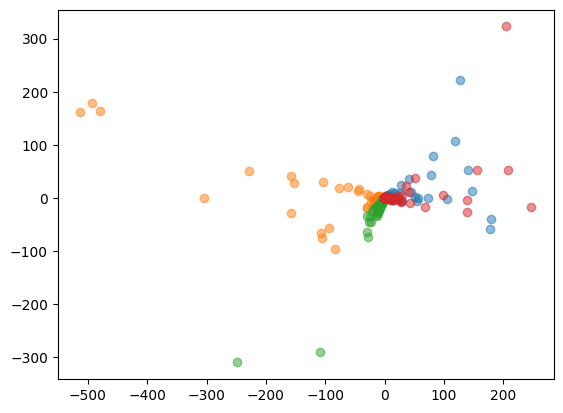

In [99]:
display_grads(labeled_data, _, cluster_sampler)